In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

# data

Load OHLC data from cryptocurrency exchange Poloniex.

In [70]:
# period = 300, 900, 1800, 7200, 14400, or 86400
ohlc_df = vbt.data.load_cryptopair('USDT_BCH', vbt.data.ago_dt(days=180), vbt.data.now_dt(), period=86400)
ohlc_df.head()

done. 0.28s


,O,H,L,C,V
date,,,,,
2017-08-14,600.0000,750.000001,200.000,304.950000,2.135129e+06
2017-08-15,300.4902,310.000200,288.999,297.900000,1.802001e+06
2017-08-16,297.9000,309.100000,286.800,299.154002,1.149004e+06
2017-08-17,300.0000,457.000000,292.000,445.100000,1.697264e+07
2017-08-18,444.1000,779.110000,436.000,694.000000,7.512503e+07


In [71]:
# No future data
rate_sr = ohlc_df.O

In [115]:
# Fees and slippage
fees = 0.0025
slippage_factor = 0.25
slippage = (ohlc_df['H'] - ohlc_df['L']) * slippage_factor / rate_sr

   count        mean        std    min         25%    50%      75%  \
O  107.0  618.707827  350.94529  297.9  377.671259  530.0  629.625   

           max  
O  1717.031055  


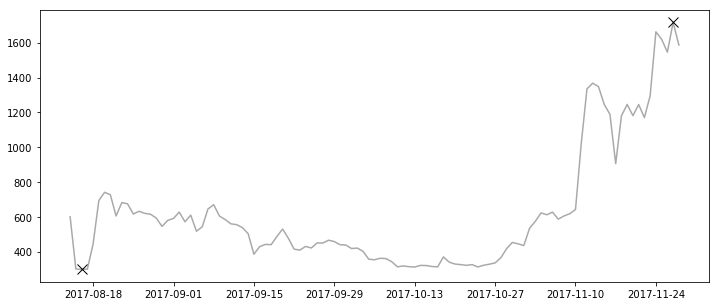

In [116]:
vbt.graphics.plot_line(rate_sr)

# indicators

Calculate EMA indicators.

In [104]:
fast_ma_sr = vbt.indicators.EMA(rate_sr, 10)
slow_ma_sr = vbt.indicators.EMA(rate_sr, 40)

# signals

Generate signals based on conditions.

    1. Go long whenever fast EMA is over slow EMA, while go short when opposite occurs.

In [105]:
ma_entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
ma_exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [106]:
ma_entries = vbt.bitvector.first(ma_entries)
ma_exits = vbt.bitvector.first(ma_exits)

    2. Go short whenever price drops by 10%.

In [107]:
# trailstop_exits = vbt.signals.trailstop_exits(rate_sr, ma_entries, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and pick every first exit out of sequence.

In [108]:
# ma_exits = vbt.bitvector.OR(ma_exits, trailstop_exits)
# ma_exits = vbt.bitvector.first(ma_exits)

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations.

# positions

Generete positions out of both vectors (merge and reduce).

In [109]:
pos_sr = vbt.positions.from_signals(rate_sr, ma_entries, ma_exits)
pos_sr.head()

date
2017-11-01    1
2017-11-28   -1
dtype: int64

Position series is a binary series, where 1 = going long and -1 = going short. There is no two long/short positions in a row, since we want a clean way to evaluate a strategy (only the logic of a strategy must have an impact on the equity, not the investment size or its distribution)

Visualize entries and exits.

   count     mean  std      min      25%      50%      75%      max
0    1.0  1151.89  NaN  1151.89  1151.89  1151.89  1151.89  1151.89


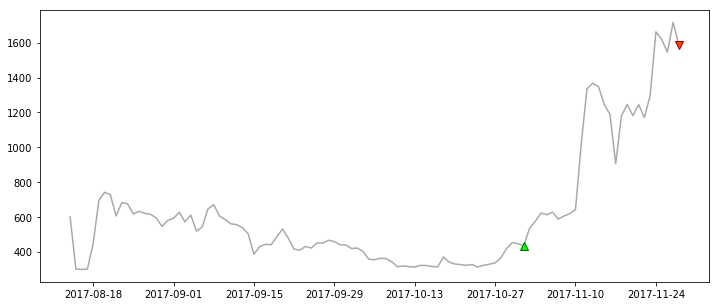

In [110]:
vbt.positions.plot(rate_sr, pos_sr)

# equity

Generate equity from positions, based on fees and slippage.

In [111]:
equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
equity_sr.head()

date
2017-08-14   NaN
2017-08-15   NaN
2017-08-16   NaN
2017-08-17   NaN
2017-08-18   NaN
dtype: float64

Equity is NaN before the first entry or if no positions were taken.

Visualize base and quote equities.

base
   count       mean         std         min         25%         50%  \
0   28.0  303.45197  114.894051  124.647978  178.006366  338.183305   

          75%         max  
0  383.388286  491.885842  


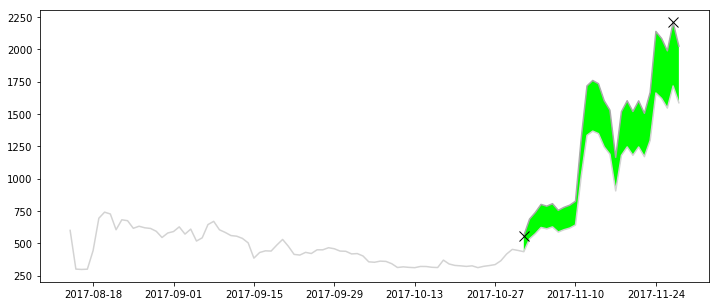

quote
   count      mean       std       min       25%       50%       75%       max
0   28.0  0.286096  0.002002  0.275881  0.286475  0.286475  0.286475  0.286475


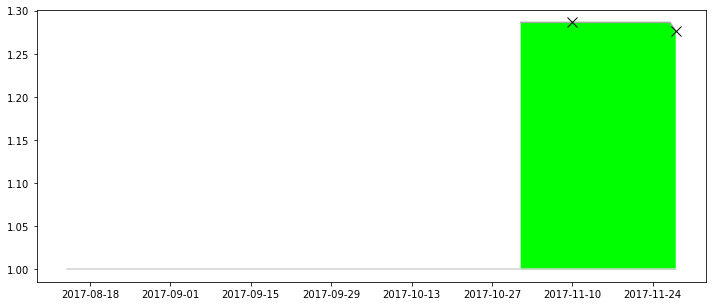

In [112]:
vbt.equity.plot(rate_sr, equity_sr)

# returns

Generate returns.

In [113]:
returns_sr = vbt.returns.from_equity(equity_sr)
returns_sr.head()

date
2017-08-14    0.0
2017-08-15    0.0
2017-08-16    0.0
2017-08-17    0.0
2017-08-18    0.0
dtype: float64

Draw returns.

   count      mean       std  min  25%  50%       75%       max
0    4.0  0.654329  1.308659  0.0  0.0  0.0  0.654329  2.617318


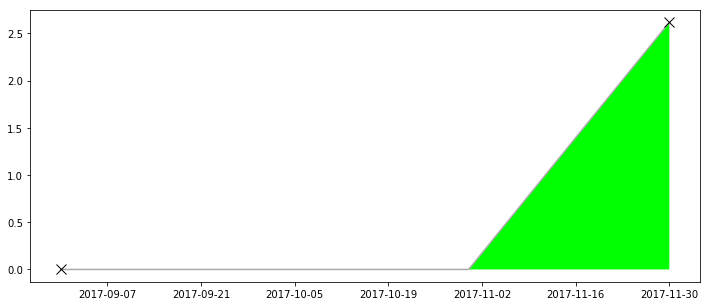

In [114]:
vbt.returns.plot(vbt.returns.resample(returns_sr, 'M'))

# performance

Print summary of multiple KPIs applied on returns.

In [85]:
vbt.performance.summary(returns_sr)

distribution         count         107.000000
                     mean            0.011232
                     std             0.082575
                     min            -0.238365
                     25%             0.000000
                     50%             0.000000
                     75%             0.000000
                     max             0.588785
performance          profit          1.453635
                     avggain         0.160627
                     avgloss         0.072574
                     winrate         0.545455
                     expectancy      0.066074
                     maxdd           0.338028
risk/return profile  sharpe          0.136018
                     sortino         0.177150
dtype: float64

# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 3-4 levels:**

| Level | Motivation | Module | Structure |
|-|-|-|-|
| 1 | Calculate position/equity/returns maps | `srmap` | `{param: pd.Series}` |
| 2 | Calculate KPIs | `nummap` | `pd.Series` |
| 3 (optional) | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Build heatmap to examine hidden patterns | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies.

## L1
## srmap

In [86]:
import vectorbt.optimizer.gridsearch as grids

Calculate returns for a set of MA window combinations.

    1. Precalculate all MAs.

In [87]:
# Init
ma_func = lambda window: vbt.indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 100, 1
fees = 0.0025

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
ma_cache = dict(grids.srmap.from_func(ma_func, param_range))

cores: 4
processes: 1
starmap: False
calcs: 100 (~0.10s) ..
done. 0.04s


    2. For each MA combination, generate position series.

In [88]:
# Params
ma_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)

# Func
def ma_positions_func(fast_ma, slow_ma):
    # Cache
    fast_ma_sr = ma_cache[fast_ma]
    slow_ma_sr = ma_cache[slow_ma]
    # Signals
    entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
    entries = vbt.bitvector.first(entries)
    exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)
    exits = vbt.bitvector.first(exits)
    # Positions
    pos_sr = vbt.positions.from_signals(rate_sr, entries, exits)
    return pos_sr

In [89]:
ma_positions_srmap = grids.srmap.from_func(ma_positions_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~6.61s) ..
done. 2.22s


    3. For each position series, generate returns series.

We need to separate position and returns calculation, since we need number of positions of each MA combination for a random map.

In [90]:
def ma_returns_func(fast_ma, slow_ma):
    # Equity
    pos_sr = ma_positions_srmap[(fast_ma, slow_ma)]
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [91]:
ma_returns_srmap = grids.srmap.from_func(ma_returns_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~9.64s) ..
done. 6.39s


For each MA window combination generate random positions of same length and resulting returns. 

In [92]:
# Params
random_space = [(fma, sma, len(np.flatnonzero(ma_positions_srmap[(fma, sma)].values))) for fma, sma in ma_space]

# Func
def random_returns_func(slow_ma, fast_ma, n):
    # Positions
    pos_sr = vbt.positions.random(rate_sr, n)
    # Equity
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [93]:
random_returns_srmap = grids.srmap.from_func(random_returns_func, random_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~16.20s) ..
done. 6.99s


## L2
## nummap

Apply KPI on each returns series.

In [94]:
if_i_hold = vbt.performance.profit(rate_sr.pct_change())
profit = lambda r: vbt.performance.profit(r) - if_i_hold
ma_profit_nummap = grids.nummap.from_srmap(ma_returns_srmap, profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~5.74s) ..
done. 2.27s
min (1, 6): -1.95467556835
max (1, 29): 1.66714007873


In [95]:
sharpe = lambda r: vbt.performance.sharpe(r, nperiods=252)
ma_sharpe_nummap = grids.nummap.from_srmap(ma_returns_srmap, sharpe)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~1.20s) ..
done. 0.48s
min (1, 6): 0.116584591922
max (1, 28): 3.0915298139


In [96]:
random_profit_nummap = grids.nummap.from_srmap(random_returns_srmap, profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~4.93s) ..
done. 2.39s
min (3, 7, 18): -2.52328669627
max (7, 28, 4): 3.14436516792


Compare quantile distributions of EMA and random strategy.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0 -0.573499  0.769883 -1.954676 -1.381488 -0.211728 -0.043461   
benchmark  5050.0 -1.187270  1.020661 -2.523287 -1.899379 -1.642988 -0.733264   

                max  
nummap     1.667140  
benchmark  3.144365  


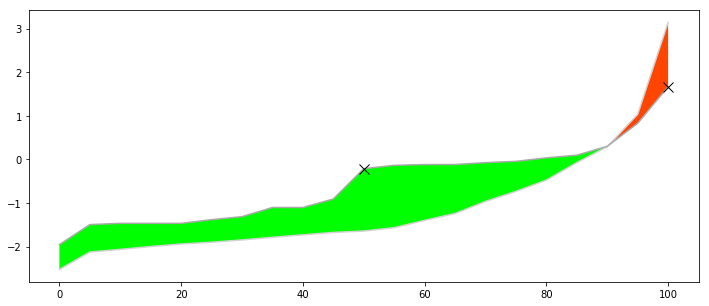

In [97]:
grids.nummap.compare_quantiles(ma_profit_nummap, random_profit_nummap)

Compare their KPI distributions.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0 -0.573499  0.769883 -1.954676 -1.381488 -0.211728 -0.043461   
benchmark  5050.0 -1.187270  1.020661 -2.523287 -1.899379 -1.642988 -0.733264   

                max  
nummap     1.667140  
benchmark  3.144365  


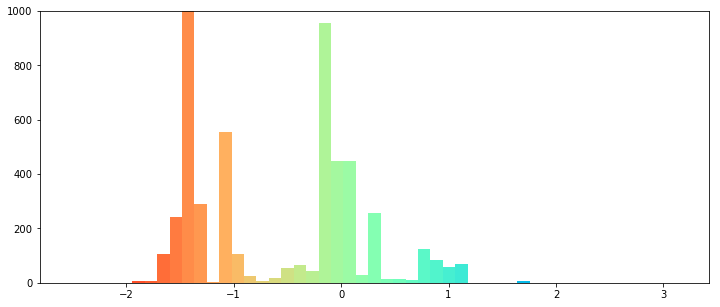

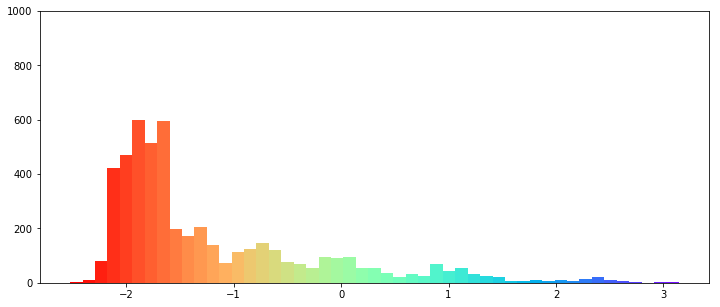

In [98]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
grids.nummap.compare_hists(ma_profit_nummap, random_profit_nummap, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100.

In [99]:
ma_scoremap = grids.scoremap.from_nummaps([ma_profit_nummap, ma_sharpe_nummap], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 6): 1.0
max (1, 30): 100.0


## L4
## matrix

Reshape 2d-parameter grid into a matrix.

In [102]:
ma_matrix = grids.matrix.from_nummap(ma_profit_nummap, symmetric=True).fillna(0)

done. 1.48s


Display as a heatmap.

     count      mean       std       min       25%       50%       75%  \
0  10000.0 -0.562784  0.766154 -1.954676 -1.380917 -0.193394 -0.043461   

       max  
0  1.66714  


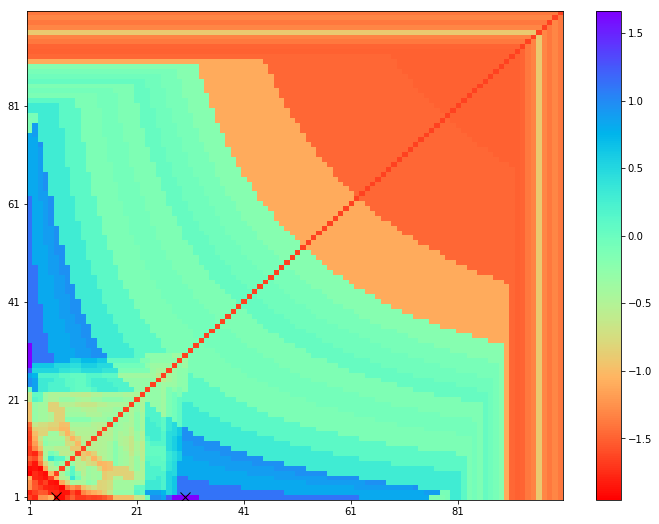

In [103]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)